In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
customers = pd.read_csv('./Dataset/olist_customers_dataset.csv')
geo = pd.read_csv('./Dataset/olist_geolocation_dataset.csv')
items = pd.read_csv('./Dataset/olist_order_items_dataset.csv')
payments = pd.read_csv('./Dataset/olist_order_payments_dataset.csv')
reviews = pd.read_csv('./Dataset/olist_order_reviews_dataset.csv')
orders= pd.read_csv('./Dataset/olist_orders_dataset.csv')
products = pd.read_csv('./Dataset/olist_products_dataset.csv')
sellers= pd.read_csv('./Dataset/olist_sellers_dataset.csv')
category = pd.read_csv('./Dataset/product_category_name_translation.csv')
     

In [3]:
dataset = [customers, geo, items, payments, orders, products, category, sellers,reviews]

In [4]:
dataset_info = pd.DataFrame({
    'dataset name' : ['customer', 'geo', 'items', 'payments','orders','products','category','sellers','reviews'],
    'n_rows' : [i.shape[0] for i in dataset],
    'n_columns' : [i.shape[1] for i in dataset],
    'columns_name': [i.columns.values for i in dataset],
    'total_missing' : [i.isna().sum().sum() for i in dataset],
    'percent_missing' : [round((i.isna().sum().sum() / (i.shape[0] * i.shape[1])) * 100, 2) for i in dataset]
})

dataset_info

,dataset name,n_rows,n_columns,columns_name,total_missing,percent_missing
0,customer,99441,5,"[customer_id, customer_unique_id, customer_zip...",0,0.00
1,geo,1000163,5,"[geolocation_zip_code_prefix, geolocation_lat,...",0,0.00
2,items,112650,7,"[order_id, order_item_id, product_id, seller_i...",0,0.00
3,payments,103886,5,"[order_id, payment_sequential, payment_type, p...",0,0.00
4,orders,99441,8,"[order_id, customer_id, order_status, order_pu...",4908,0.62
5,products,32951,9,"[product_id, product_category_name, product_na...",2448,0.83
6,category,71,2,"[product_category_name, product_category_name_...",0,0.00
7,sellers,3095,4,"[seller_id, seller_zip_code_prefix, seller_cit...",0,0.00
8,reviews,99224,7,"[review_id, order_id, review_score, review_com...",145903,21.01


In [5]:
# 1. First Merge
products_category = products.merge(category, on='product_category_name')
products_category['product_category_name'] = products_category['product_category_name_english']
products_category.drop('product_category_name_english', axis=1, inplace=True)

In [6]:
products_items = products_category.merge(items, on='product_id', how='right')
sellers_products = products_items.merge(sellers, on='seller_id')
items_orders = sellers_products.merge(orders, on='order_id')
customers_orders = items_orders.merge(customers, on='customer_id')
customers_reviews = customers_orders.merge(reviews, on='order_id')
df_merge = customers_reviews.merge(payments, on='order_id')

In [7]:
df_raw = df_merge.copy()

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   product_id                     117329 non-null  object 
 1   product_category_name          115609 non-null  object 
 2   product_name_lenght            115609 non-null  float64
 3   product_description_lenght     115609 non-null  float64
 4   product_photos_qty             115609 non-null  float64
 5   product_weight_g               115608 non-null  float64
 6   product_length_cm              115608 non-null  float64
 7   product_height_cm              115608 non-null  float64
 8   product_width_cm               115608 non-null  float64
 9   order_id                       117329 non-null  object 
 10  order_item_id                  117329 non-null  int64  
 11  seller_id                      117329 non-null  object 
 12  shipping_limit_date           

##### **PRE-CLEANING**

This step purposes to drop columns that will not be used during the analysis

In [9]:
unnecessary_columns = ['review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp','customer_zip_code_prefix','seller_zip_code_prefix','product_width_cm','product_height_cm','product_length_cm','product_weight_g','product_name_lenght','shipping_limit_date','seller_city']

In [10]:
df_raw.drop(unnecessary_columns,axis=1, inplace=True)

In [11]:
missing_values = df_raw.isna().sum()
missing_values[missing_values > 0]

product_category_name            1720
product_description_lenght       1720
product_photos_qty               1720
order_approved_at                  15
order_delivered_carrier_date     1235
order_delivered_customer_date    2471
dtype: int64

Product yang tidak memiliki nama akan didrop semua, sementara untuk order_delivery status akan di keep dikarenakan mungkin ada beberapa order yang memang belum sampai ke customer atau dibawa oleh kurir

In [12]:
df_raw = df_raw.dropna(subset=['product_category_name', 'product_description_lenght', 'product_photos_qty'])

In [13]:
df = df_raw.copy()

##### **Overall Customer Information**

Jumlah n_unique Customer yang melakukan transaksi

In [54]:
customer_orders = df.groupby(['customer_unique_id', 'order_purchase_timestamp']).agg({'order_id': 'nunique'}).reset_index()

customer_order_counts = customer_orders.groupby('customer_unique_id')['order_id'].count().reset_index()

print(f'Jumlah n_unique customer yang melakukan transaksi : {customer_order_counts.shape[0]}')

Jumlah n_unique customer yang melakukan transaksi : 93396


#### **Analisa Distribusi Metode Pembayaran**

In [60]:
overall_customers = df[df['customer_unique_id'].isin(customer_order_counts['customer_unique_id'])]

overall_customers['payment_type'].value_counts().reset_index()

,payment_type,count
0,credit_card,85278
1,boleto,22510
2,voucher,6162
3,debit_card,1659


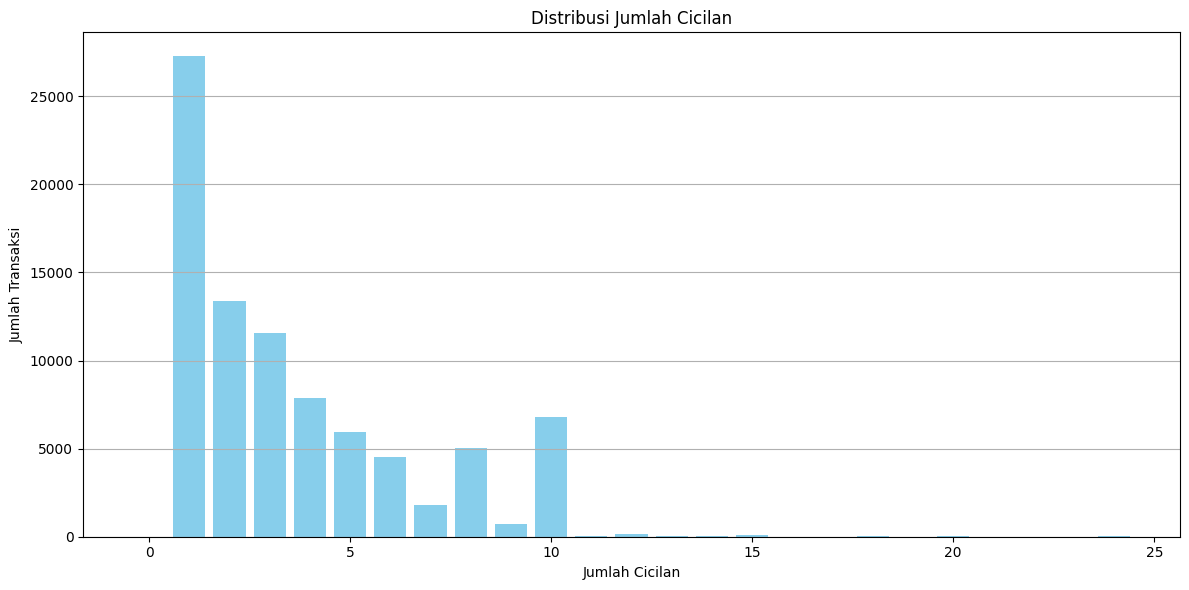

In [172]:
installments_distribution = overall_customers[overall_customers['payment_type'] == 'credit_card']['payment_installments'].value_counts().reset_index()

installments_distribution.columns = ['payment_installments', 'count']

installments_distribution = installments_distribution.sort_values(by='payment_installments')

plt.figure(figsize=(12, 6))
plt.bar(installments_distribution['payment_installments'], installments_distribution['count'], color='skyblue')
plt.title('Distribusi Jumlah Cicilan')
plt.xlabel('Jumlah Cicilan')
plt.ylabel('Jumlah Transaksi')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### **Analisa Order Status**

In [171]:
order_status = overall_customers['order_status'].value_counts().reset_index()

order_status.columns = ['order_status', 'count']

order_status['percentage'] = round((order_status['count'] / overall_customers['order_status'].count()) * 100,2)

order_status

,order_status,count,percentage
0,delivered,113210,97.92
1,shipped,1138,0.98
2,canceled,536,0.46
3,invoiced,358,0.31
4,processing,357,0.31
5,unavailable,7,0.01
6,approved,3,0.00


#### **Analisa Pembelian Kategori produk terpopuler**

Jumlah pembelian per kategori produk

In [71]:
top_categories = overall_customers['product_category_name'].value_counts().reset_index()

top_categories.columns = ['product_category_name', 'count']

top_categories['percentage'] = round((top_categories['count'] / overall_customers['product_category_name'].count()) * 100,2)

top_categories.head(5)


,product_category_name,count,percentage
0,bed_bath_table,11847,10.25
1,health_beauty,9944,8.60
2,sports_leisure,8942,7.73
3,furniture_decor,8743,7.56
4,computers_accessories,8105,7.01


Kategori Produk dengan Harga Rata-Rata Tertinggi

In [278]:
average_price_per_category = overall_customers.groupby('product_category_name')['price'].mean().reset_index()

average_price_per_category.columns = ['product_category_name', 'average_price']

average_price_per_category = average_price_per_category.sort_values(by='average_price', ascending=False)

average_price_per_category.head()

,product_category_name,average_price
46,home_comfort_2,26.231071
35,flowers,32.265806
23,diapers_and_hygiene,40.194615
11,cds_dvds_musicals,52.142857
12,christmas_supplies,54.838649


Rata-rata jumlah foto per kategori produk

In [134]:

average_photos_per_category = overall_customers.groupby('product_category_name')['product_photos_qty'].mean().reset_index()

average_photos_per_category.columns = ['product_category_name', 'average_photos']

average_photos_per_category = average_photos_per_category.sort_values(by='average_photos', ascending=False)

average_photos_per_category.head()


,product_category_name,average_photos
31,fashion_shoes,5.307692
64,small_appliances_home_oven_and_coffee,4.294872
3,arts_and_craftmanship,3.708333
28,fashion_bags_accessories,3.695229
51,kitchen_dining_laundry_garden_furniture,3.528620


Rata - rata panjang deskripsi per kategori produk

In [136]:
average_description_length_per_category = overall_customers.groupby('product_category_name')['product_description_lenght'].mean().reset_index()

average_description_length_per_category.columns = ['product_category_name', 'average_description_length']

average_description_length_per_category = average_description_length_per_category.sort_values(by='average_description_length', ascending=False)


average_description_length_per_category.head()


,product_category_name,average_description_length
14,computers,2638.705069
55,music,1470.875000
64,small_appliances_home_oven_and_coffee,1367.512821
19,construction_tools_safety,1334.368687
10,books_technical,1321.747212


Rata - rata review score per kategori produk

In [153]:
average_review_score_per_category = overall_customers.groupby('product_category_name')['review_score'].mean().reset_index()

average_review_score_per_category.columns = ['product_category_name', 'average_review_score']

average_review_score_per_category.sort_values(by='average_review_score', ascending=False).head(5)

,product_category_name,average_review_score
11,cds_dvds_musicals,4.642857
29,fashion_childrens_clothes,4.500000
8,books_general_interest,4.438503
9,books_imported,4.419355
35,flowers,4.419355


Distribusi Kategori produk berdasarkan pembelian

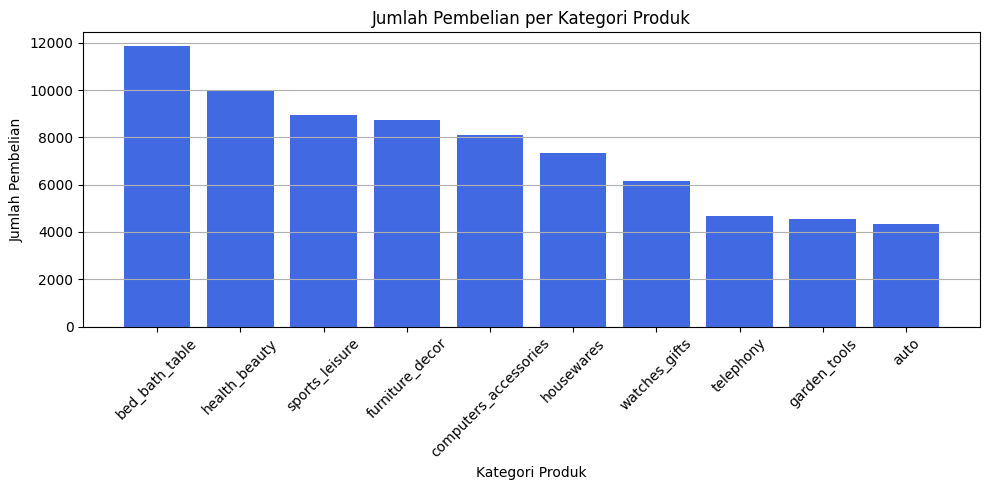

In [159]:
plt.figure(figsize=(10, 5))
plt.bar(top_categories.head(10)['product_category_name'], top_categories.head(10)['count'], color='royalblue')
plt.title('Jumlah Pembelian per Kategori Produk')
plt.xlabel('Kategori Produk')
plt.ylabel('Jumlah Pembelian')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Distribusi hubungan Kategori Produk berdasarkan Banyak Pembelian, Score, Review, Deskripsi dan Foto

In [160]:
combined_data = top_categories.merge(average_price_per_category, on='product_category_name')
combined_data = combined_data.merge(average_photos_per_category, on='product_category_name')
combined_data = combined_data.merge(average_description_length_per_category, on='product_category_name')
combined_data = combined_data.merge(average_review_score_per_category, on='product_category_name')
combined_data = combined_data.sort_values(by='count', ascending=False).head(10)

In [157]:
combined_data

,product_category_name,count,percentage,average_price,average_photos,average_description_length,average_review_score
0,bed_bath_table,11847,10.25,92.493462,1.490251,442.190597,3.890605
1,health_beauty,9944,8.60,129.815318,1.829545,1112.766995,4.137973
2,sports_leisure,8942,7.73,114.346823,2.194811,1087.527399,4.107470
3,furniture_decor,8743,7.56,87.537083,2.484845,770.605970,3.912158
4,computers_accessories,8105,7.01,116.593774,1.736089,804.837754,3.936089
5,housewares,7331,6.34,90.605205,2.323694,689.901378,4.060428
6,watches_gifts,6161,5.33,202.204692,2.504139,639.131472,4.017692
7,telephony,4692,4.06,71.574772,2.900043,760.077579,3.948849
8,garden_tools,4558,3.94,113.204864,2.191312,742.681220,4.023914
9,auto,4356,3.77,139.787489,2.512626,872.684343,4.064279


C:\Users\user\AppData\Local\Temp\ipykernel_20732\275451266.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(combined_data['product_category_name'], rotation=45, ha='right')


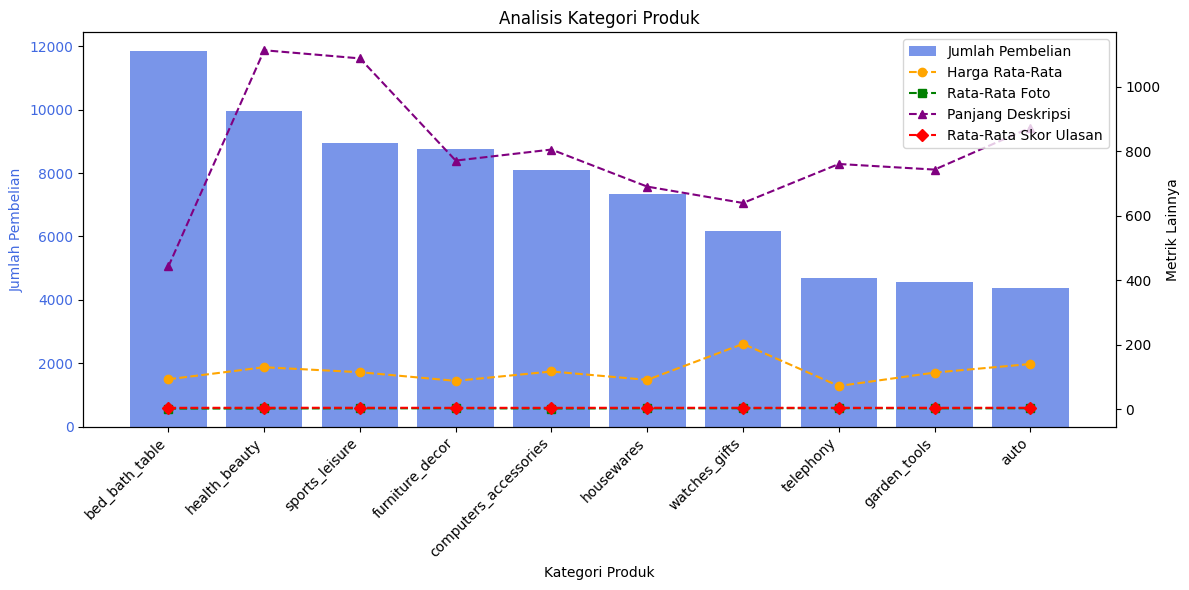

In [162]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(combined_data['product_category_name'], combined_data['count'], color='royalblue', alpha=0.7, label='Jumlah Pembelian')
ax1.set_xlabel('Kategori Produk')
ax1.set_ylabel('Jumlah Pembelian', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

ax1.set_xticklabels(combined_data['product_category_name'], rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(combined_data['product_category_name'], combined_data['average_price'], color='orange', marker='o', label='Harga Rata-Rata', linestyle='--')
ax2.plot(combined_data['product_category_name'], combined_data['average_photos'], color='green', marker='s', label='Rata-Rata Foto', linestyle='--')
ax2.plot(combined_data['product_category_name'], combined_data['average_description_length'], color='purple', marker='^', label='Panjang Deskripsi', linestyle='--')
ax2.plot(combined_data['product_category_name'], combined_data['average_review_score'], color='red', marker='D', label='Rata-Rata Skor Ulasan', linestyle='--')
ax2.set_ylabel('Metrik Lainnya', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Menambahkan legenda
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.title('Analisis Kategori Produk')
plt.tight_layout()
plt.show()


#### **Analisa Distribusi Review Score**

In [168]:
top_reviews = overall_customers['review_score'].value_counts().reset_index()

top_reviews.columns = ['review_score', 'count']

top_reviews['percentage'] = round((top_reviews['count'] / overall_customers['review_score'].count()) * 100,2)

top_reviews

,review_score,count,percentage
0,5,65374,56.55
1,4,21951,18.99
2,1,14546,12.58
3,3,9718,8.41
4,2,4020,3.48


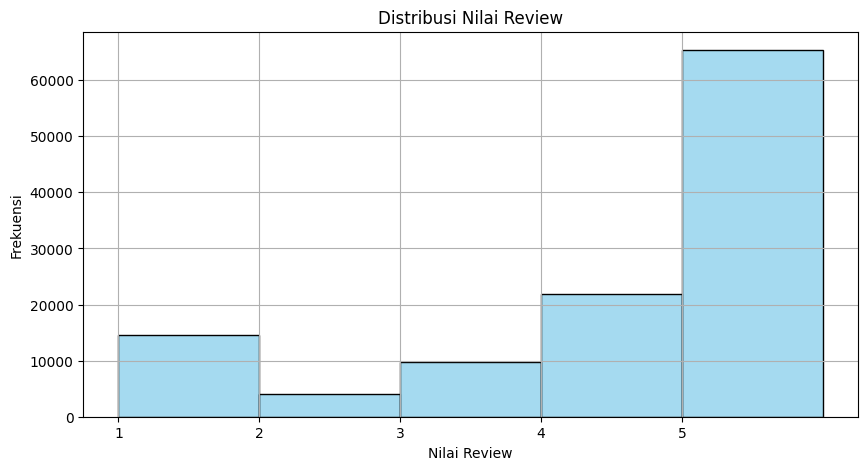

In [167]:
plt.figure(figsize=(10, 5))
sns.histplot(overall_customers['review_score'], bins=range(1, 7), kde=False, color='skyblue')
plt.title('Distribusi Nilai Review')
plt.xlabel('Nilai Review')
plt.ylabel('Frekuensi')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()


#### **Analisa Trend Pembelian**

Grafik trend pembelian berdasarkan bulan

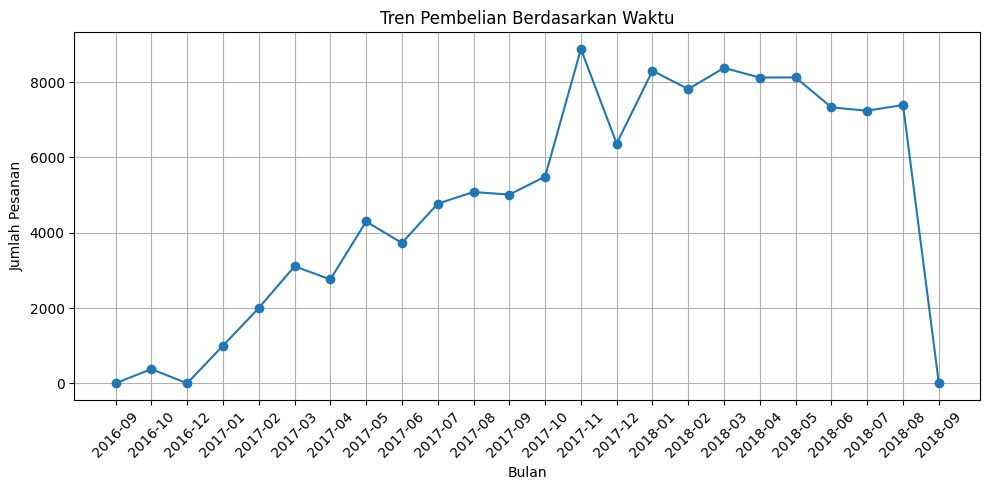

In [113]:
overall_customers['order_purchase_timestamp'] = pd.to_datetime(overall_customers['order_purchase_timestamp'])

overall_customers['purchase_month'] = overall_customers['order_purchase_timestamp'].dt.to_period('M')

monthly_orders = overall_customers.groupby('purchase_month').size().reset_index(name='order_count')

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(monthly_orders['purchase_month'].astype(str), monthly_orders['order_count'], marker='o', linestyle='-')
plt.title('Tren Pembelian Berdasarkan Waktu')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Pesanan')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Bar chart Trend pembelian berdasarkan hari

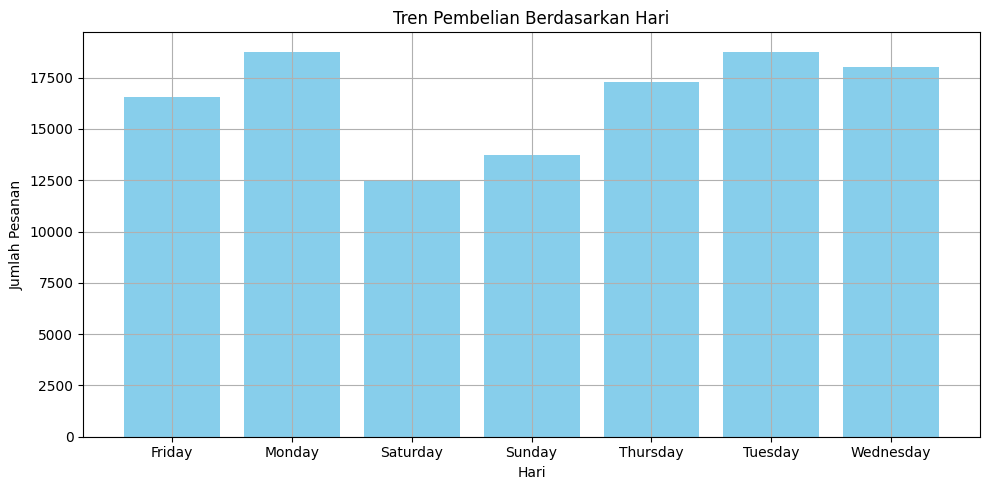

In [115]:
overall_customers['purchase_day'] = overall_customers['order_purchase_timestamp'].dt.day_name()

daily_orders = overall_customers.groupby('purchase_day').size().reset_index(name='order_count')

#Visualization
plt.figure(figsize=(10, 5))
plt.bar(daily_orders['purchase_day'], daily_orders['order_count'], color='skyblue')
plt.title('Tren Pembelian Berdasarkan Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Pesanan')
plt.grid(True)
plt.tight_layout()
plt.show()

Grafik Trend pembelian berdasarkan hari

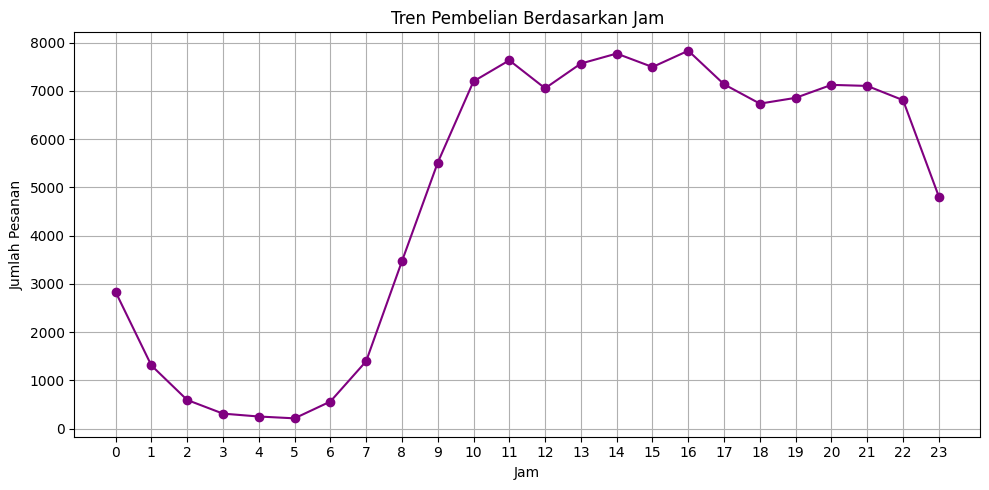

In [114]:
overall_customers['purchase_hour'] = overall_customers['order_purchase_timestamp'].dt.hour

hourly_orders = overall_customers.groupby('purchase_hour').size().reset_index(name='order_count')

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(hourly_orders['purchase_hour'], hourly_orders['order_count'], marker='o', linestyle='-', color='purple')
plt.title('Tren Pembelian Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Jumlah Pesanan')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Analisa Distribusi Transaksi / Pembelian**

Distribusi Pengiriman berdasarkan Kota

In [118]:
top_citys = overall_customers['customer_city'].value_counts().reset_index()

top_citys.columns = ['customer_city', 'count']

top_citys['percentage'] = round((top_citys['count'] / overall_customers['customer_city'].count()) * 100,2)

top_citys.head(5)

,customer_city,count,percentage
0,sao paulo,18267,15.80
1,rio de janeiro,8022,6.94
2,belo horizonte,3196,2.76
3,brasilia,2434,2.11
4,curitiba,1790,1.55


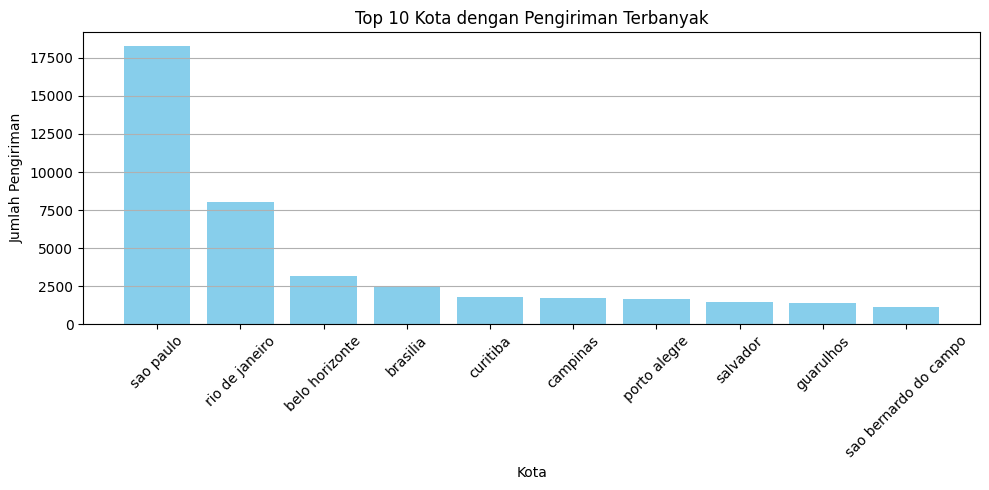

In [112]:
city_distribution = overall_customers['customer_city'].value_counts().reset_index()
city_distribution.columns = ['customer_city', 'count']

# Visualization
plt.figure(figsize=(10, 5))
plt.bar(city_distribution['customer_city'][:10], city_distribution['count'][:10], color='skyblue')
plt.title('Top 10 Kota dengan Pengiriman Terbanyak')
plt.xlabel('Kota')
plt.ylabel('Jumlah Pengiriman')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Distribusi Pengiriman berdasarkan Wilayah

In [117]:
top_states = overall_customers['customer_state'].value_counts().reset_index()

top_states.columns = ['customer_state', 'count']

top_states['percentage'] = round((top_states['count'] / overall_customers['customer_state'].count()) * 100,2)

top_states.head(5)

,customer_state,count,percentage
0,SP,48797,42.21
1,RJ,14987,12.96
2,MG,13429,11.62
3,RS,6413,5.55
4,PR,5879,5.09


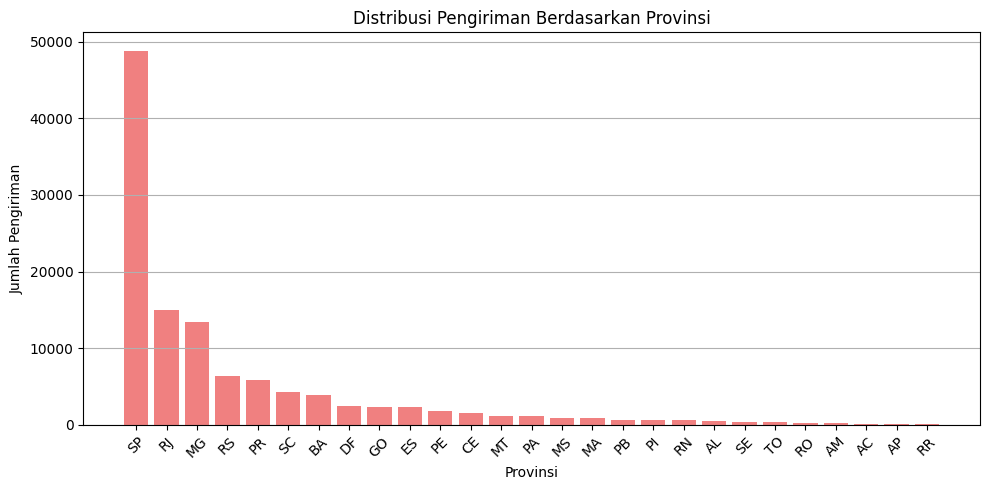

In [111]:
state_distribution = overall_customers['customer_state'].value_counts().reset_index()
state_distribution.columns = ['customer_state', 'count']

# Visualization
plt.figure(figsize=(10, 5))
plt.bar(state_distribution['customer_state'], state_distribution['count'], color='lightcoral')
plt.title('Distribusi Pengiriman Berdasarkan Provinsi')
plt.xlabel('Provinsi')
plt.ylabel('Jumlah Pengiriman')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### **Analisa Distribusi Waktu Pengiriman Order**

In [189]:
# Mengonversi kolom waktu ke tipe datetime
overall_customers['order_purchase_timestamp'] = pd.to_datetime(overall_customers['order_purchase_timestamp'])
overall_customers['order_approved_at'] = pd.to_datetime(overall_customers['order_approved_at'])
overall_customers['order_delivered_carrier_date'] = pd.to_datetime(overall_customers['order_delivered_carrier_date'])
overall_customers['order_delivered_customer_date'] = pd.to_datetime(overall_customers['order_delivered_customer_date'])
overall_customers['order_estimated_delivery_date'] = pd.to_datetime(overall_customers['order_estimated_delivery_date'])


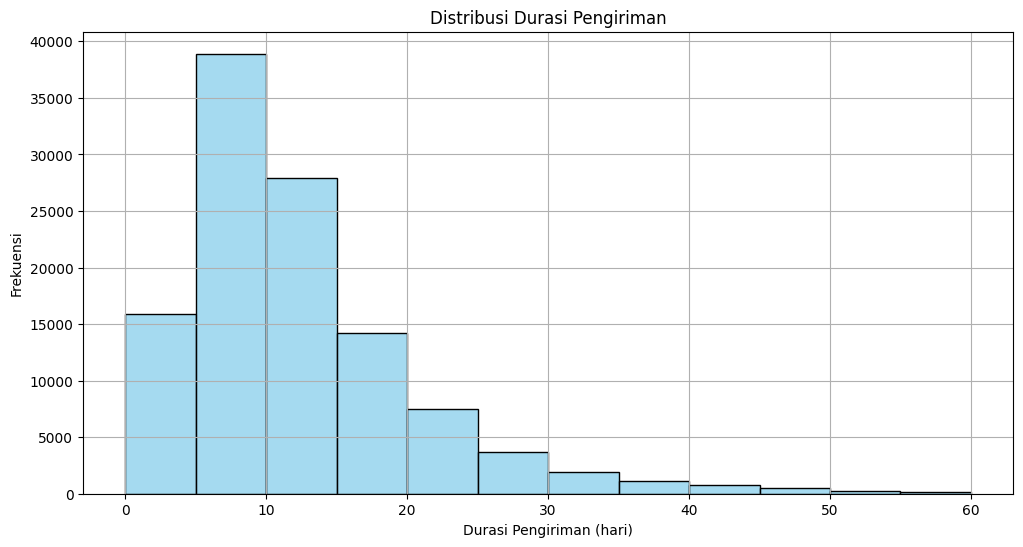

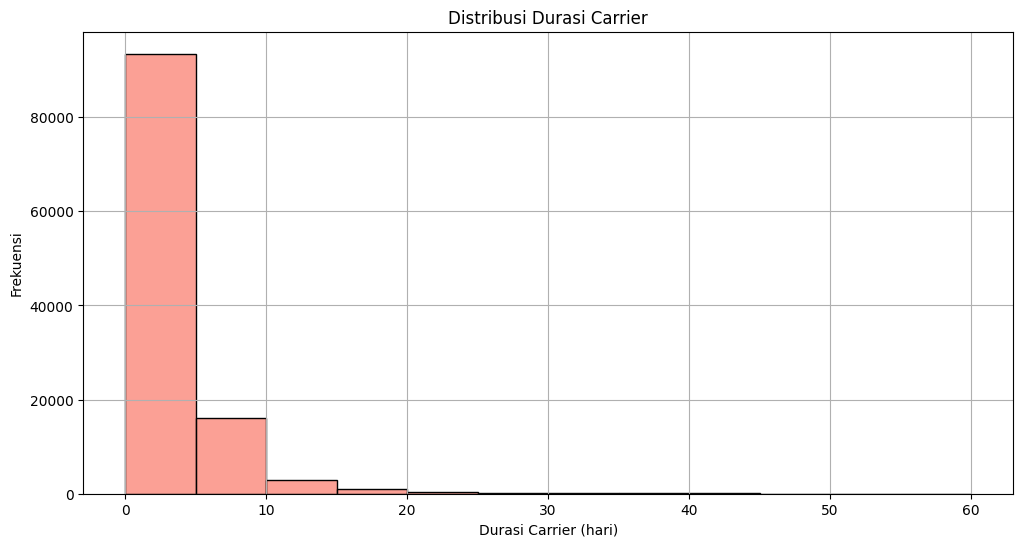

In [190]:
plt.figure(figsize=(12, 6))
sns.histplot(overall_customers['delivery_duration'], bins=range(0, 61, 5), kde=False, color='skyblue')
plt.title('Distribusi Durasi Pengiriman')
plt.xlabel('Durasi Pengiriman (hari)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(overall_customers['carrier_duration'], bins=range(0, 61, 5), kde=False, color='salmon')
plt.title('Distribusi Durasi Carrier')
plt.xlabel('Durasi Carrier (hari)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()


In [191]:
# Rata-rata durasi pengiriman per kategori produk
average_delivery_per_category = overall_customers.groupby('product_category_name')['delivery_duration'].mean().reset_index()
average_delivery_per_category.columns = ['product_category_name', 'average_delivery_duration']
average_delivery_per_category = average_delivery_per_category.sort_values(by='average_delivery_duration', ascending=True)

# Menampilkan DataFrame
average_delivery_per_category.head()


,product_category_name,average_delivery_duration
3,arts_and_craftmanship,5.291667
52,la_cuisine,6.800000
9,books_imported,7.847458
29,fashion_childrens_clothes,8.142857
58,party_supplies,8.644444


In [184]:
# Rata-rata durasi pengiriman per negara bagian
average_delivery_per_state = overall_customers.groupby('customer_state')['delivery_duration'].mean().reset_index()
average_delivery_per_state.columns = ['customer_state', 'average_delivery_duration']
average_delivery_per_state = average_delivery_per_state.sort_values(by='average_delivery_duration', ascending=True)

# Menampilkan DataFrame
average_delivery_per_state.head()


,customer_state,average_delivery_duration
25,SP,8.256624
10,MG,11.482109
17,PR,11.496546
6,DF,12.492699
23,SC,14.384745


#### **Analisa Hubungan Pembelian dengan Harga produk dan Review**

Hubungan harga produk dan Nilai review

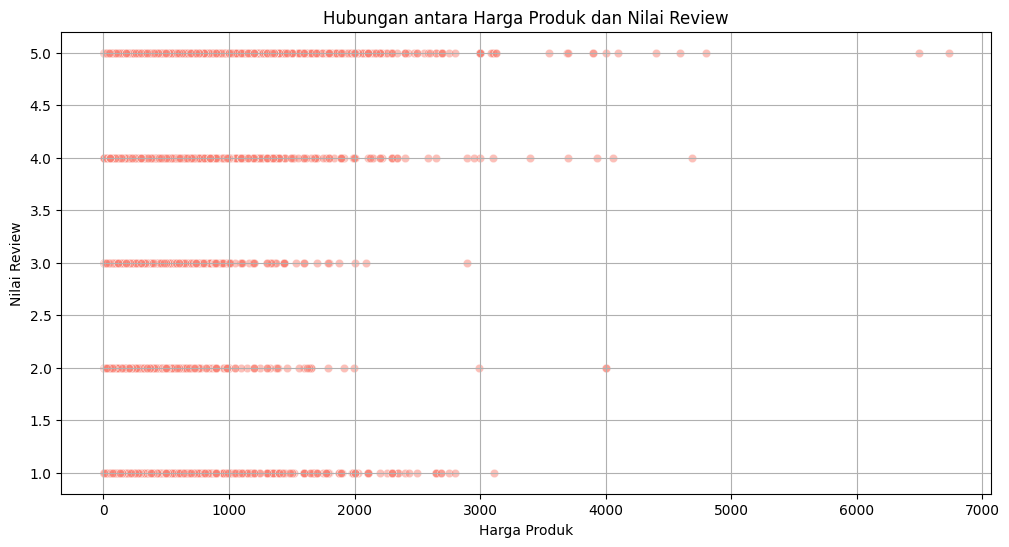

In [195]:
# Scatter plot antara harga produk dan nilai review
plt.figure(figsize=(12, 6))
sns.scatterplot(x='price', y='review_score', data=overall_customers, color='salmon', alpha=0.5)
plt.title('Hubungan antara Harga Produk dan Nilai Review')
plt.xlabel('Harga Produk')
plt.ylabel('Nilai Review')
plt.grid(True)
plt.show()


Hubungan Harga produk dengan banyak pembelian 

In [198]:
# Menentukan rentang harga
price_bins = [0, 20, 50, 100, 200, 500, 1000, float('inf')]
price_labels = ['0-20', '21-50', '51-100', '101-200', '201-500', '501-1000', '1000+']
overall_customers['price_range'] = pd.cut(overall_customers['price'], bins=price_bins, labels=price_labels)

# Jumlah pembelian per rentang harga
purchase_count_per_price_range = overall_customers['price_range'].value_counts().reset_index()
purchase_count_per_price_range.columns = ['price_range', 'count']
purchase_count_per_price_range = purchase_count_per_price_range.sort_values(by='count', ascending=False)

# Menampilkan DataFrame
print("Jumlah Pembelian per Rentang Harga:")
purchase_count_per_price_range


Jumlah Pembelian per Rentang Harga:


,price_range,count
0,51-100,34236
1,21-50,30609
2,101-200,27294
3,201-500,10464
4,0-20,9691
5,501-1000,2451
6,1000+,864


#### **Customer Purchase Behaviour**

##### **1. Customer First Time Purchase**

Jumlah customer yang baru melakukan pembelian pertama kali

In [206]:
customer_orders = df.groupby(['customer_unique_id', 'order_purchase_timestamp']).agg({'order_id': 'nunique'}).reset_index()

customer_order_counts = customer_orders.groupby('customer_unique_id')['order_id'].count()

first_purchase = customer_order_counts[customer_order_counts == 1].reset_index()

print(f"Jumlah pelanggan yang melakukan pembelian pertama : {first_purchase.shape[0]} customer")

Jumlah pelanggan yang melakukan pembelian pertama : 90829 customer


Category product yang paling banyak dibeli oleh customer pertama

In [240]:
df_first_purchase = df[df['customer_unique_id'].isin(first_purchase['customer_unique_id'])]

most_cat_first_purchase = df_first_purchase['product_category_name'].value_counts().reset_index().head(5)

most_cat_first_purchase

,product_category_name,count
0,bed_bath_table,10649
1,health_beauty,9405
2,sports_leisure,8271
3,furniture_decor,7932
4,computers_accessories,7541


Payment type yang paling banyak digunakan oleh customer pertama

In [17]:
first_purchase_payments = df_first_purchase['payment_type'].value_counts().reset_index()

first_purchase_payments

,payment_type,count
0,credit_card,79901
1,boleto,21087
2,voucher,5562
3,debit_card,1578


Customer yang telah melakukan pembelian pertama hanya 1 item

In [227]:
# Mengelompokkan data berdasarkan customer_unique_id dan menghitung jumlah item yang dibeli
customer_purchase_info = df_first_purchase.groupby('customer_unique_id').agg({
    'order_item_id': 'size',
    'product_category_name': lambda x: x.unique(),
    'payment_type' : lambda x:x.unique(),
}).reset_index()

In [229]:
first_purchase_one_item = customer_purchase_info[customer_purchase_info['order_item_id'] == 1]
print(f'jumlah customer yang membeli 1 item dalam pembelian pertama : {first_purchase_one_item.shape[0]} customer')

jumlah customer yang membeli 1 item dalam pembelian pertama : 79377 customer


Category product yang paling banyak dibeli oleh customer pertama hanya 1 item

In [232]:
most_cat_first_purchase_one_item = first_purchase_one_item['product_category_name'].value_counts().reset_index().head(5)

most_cat_first_purchase_one_item

,product_category_name,count
0,[health_beauty],7480
1,[bed_bath_table],6930
2,[sports_leisure],6200
3,[computers_accessories],5384
4,[watches_gifts],4881


Customer yang melakukan pembelian pertama kali lebih dari 1 item

In [233]:
first_purchase_many_item = customer_purchase_info[customer_purchase_info['order_item_id'] > 1]

print(f'jumlah customer yang membeli 1 item dalam pembelian pertama : {first_purchase_many_item.shape[0]} customer')

jumlah customer yang membeli 1 item dalam pembelian pertama : 11452 customer


Category product yang paling banyak dibeli oleh customer pertama lebih dari 1 item

In [235]:
most_cat_first_purchase_one_item = first_purchase_many_item['product_category_name'].value_counts().reset_index().head(5)

most_cat_first_purchase_one_item

,product_category_name,count
0,[bed_bath_table],1398
1,[furniture_decor],1219
2,[sports_leisure],843
3,[computers_accessories],828
4,[housewares],793


##### **2.Customer Repeat Purchase**

Customer yang telah melakukan pembelian secara berulang kali 

In [268]:
repeat_customers = customer_order_counts[customer_order_counts['order_id'] > 1]

In [269]:
customer_repeat_purchase = df[df['customer_unique_id'].isin(repeat_customers['customer_unique_id'])]

In [272]:
print(f"Jumlah pelanggan yang melakukan pembelian berulang: {repeat_customers.shape[0]} customer")


Jumlah pelanggan yang melakukan pembelian berulang: 2567 customer


Jumlah pembelian berulang terbanyak yang dilakukan oleh customer 

In [273]:
repeat_customers.rename(columns={'order_id' : 'purchase_count'}).sort_values(by='purchase_count', ascending = False).head(5)

,customer_unique_id,purchase_count
51506,8d50f5eadf50201ccdcedfb9e2ac8455,15
22823,3e43e6105506432c953e165fb2acf44c,9
36755,6469f99c1f9dfae7733b25662e7f1782,7
10077,1b6c7548a2a1f9037c1fd3ddfed95f33,7
73978,ca77025e7201e3b30c44b472ff346268,7


Distribusi jangka waktu pembelian berulang customer

In [255]:
customer_repeat_purchase['order_purchase_timestamp'] = pd.to_datetime(customer_repeat_purchase['order_purchase_timestamp'])

customer_repeat_purchase = customer_repeat_purchase.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

customer_repeat_purchase['previous_purchase'] = customer_repeat_purchase.groupby('customer_unique_id')['order_purchase_timestamp'].shift(1)

customer_repeat_purchase['time_difference'] = (customer_repeat_purchase['order_purchase_timestamp'] - customer_repeat_purchase['previous_purchase']).dt.days

customer_repeat_purchase = customer_repeat_purchase.dropna(subset=['time_difference'])

customer_repeat_purchase[['customer_unique_id', 'order_purchase_timestamp', 'previous_purchase', 'time_difference']].sort_values(by='time_difference', ascending=False).head(5)


,customer_unique_id,order_purchase_timestamp,previous_purchase,time_difference
100815,495fe7ae31686381c8145b2936e761dc,2018-08-05 18:25:52,2017-08-30 14:16:14,340.0
12850,4e65032f1f574189fb793bac5a867bbc,2018-06-14 09:28:49,2017-07-16 12:26:05,332.0
109975,dc813062e0fc23409cd255f7f53c7074,2018-08-23 00:07:26,2017-11-25 18:35:17,270.0
61470,9cc5a07f169a1606fd347a56683e6ea6,2018-08-22 01:37:38,2017-12-13 21:34:31,251.0
41268,738ffcf1017b584e9d2684b36e07469c,2018-05-11 23:49:18,2017-11-01 01:52:21,191.0


In [253]:
def categorize_time_difference(days):
    if days <= 7:
        return '1 Minggu'
    elif days <= 14:
        return '2 Minggu'
    elif days <= 30:
        return '1 Bulan'
    elif days <= 60:
        return '2 Bulan'
    elif days <= 90:
        return '3 Bulan'
    else:
        return 'Lebih dari 3 Bulan'

customer_repeat_purchase['time_category'] = customer_repeat_purchase['time_difference'].apply(categorize_time_difference)

time_distribution = customer_repeat_purchase['time_category'].value_counts().reset_index()

time_distribution.columns = ['time_category', 'count']

time_distribution


,time_category,count
0,1 Minggu,1116
1,Lebih dari 3 Bulan,90
2,2 Bulan,51
3,2 Minggu,25
4,1 Bulan,25
5,3 Bulan,22


C:\Users\user\AppData\Local\Temp\ipykernel_20732\1378412912.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_category', y='count', data=time_distribution, palette='viridis')


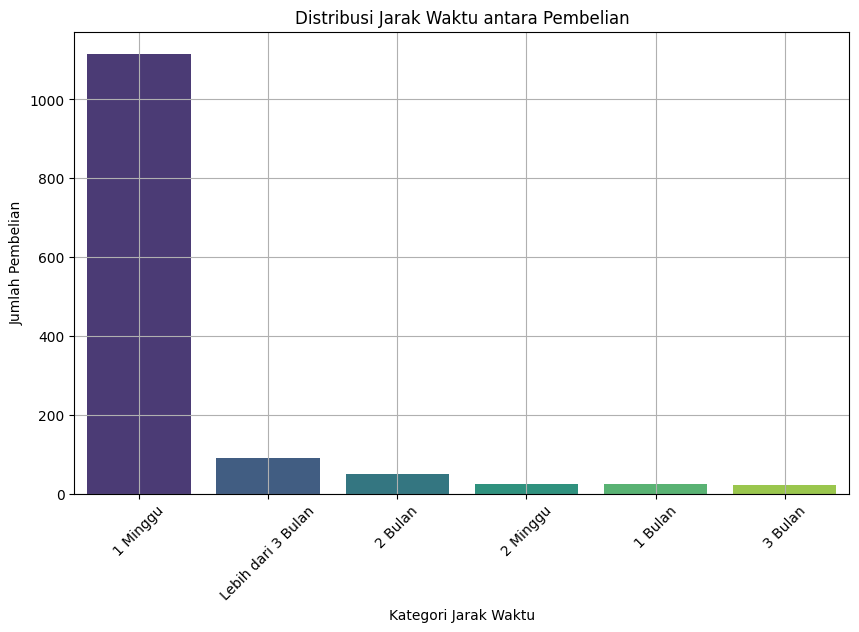

In [252]:
plt.figure(figsize=(10, 6))
sns.barplot(x='time_category', y='count', data=time_distribution, palette='viridis')
plt.title('Distribusi Jarak Waktu antara Pembelian')
plt.xlabel('Kategori Jarak Waktu')
plt.ylabel('Jumlah Pembelian')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [221]:
# Mengelompokkan data berdasarkan customer_unique_id dan menghitung jumlah item yang dibeli
customer_purchase_info = customer_repeat_purchase.groupby(['customer_unique_id']).agg({
    'order_id': 'nunique', 
    'order_item_id': 'sum',  # Menjumlahkan item dalam setiap pesanan untuk setiap customer
    'product_category_name': lambda x: ', '.join(x.unique()),  # Menggabungkan kategori produk unik
    'payment_type': lambda x: ', '.join(x.unique())  # Menggabungkan jenis pembayaran unik
}).reset_index()

customer_purchase_info.sort_values(by='order_id', ascending=False).head()


,customer_unique_id,order_id,order_item_id,product_category_name,payment_type
1421,8d50f5eadf50201ccdcedfb9e2ac8455,15,15,"sports_leisure, fashion_bags_accessories, cost...",credit_card
616,3e43e6105506432c953e165fb2acf44c,9,22,"furniture_decor, bed_bath_table, home_construc...",credit_card
2043,ca77025e7201e3b30c44b472ff346268,7,21,"housewares, furniture_decor, bed_bath_table, c...","boleto, credit_card"
1000,6469f99c1f9dfae7733b25662e7f1782,7,11,bed_bath_table,credit_card
287,1b6c7548a2a1f9037c1fd3ddfed95f33,7,12,"health_beauty, perfumery, furniture_decor, hou...","boleto, voucher, credit_card"


Category product yang paling banyak dibeli oleh customer yang melakukan pembelian berulang

In [239]:
customer_repeat_purchase['product_category_name'].value_counts().reset_index().head()

,product_category_name,count
0,bed_bath_table,1198
1,furniture_decor,811
2,sports_leisure,671
3,computers_accessories,564
4,health_beauty,539


##### **3. Customer Purchase Distribution**

In [275]:
first_purchase_one_item.shape[0]
first_purchase_many_item.shape[0]
repeat_customers.shape[0]

data = [first_purchase_one_item.shape[0], first_purchase_many_item.shape[0], repeat_customers.shape[0]]
labels = ['First Purchase - One Item', 'First Purchase - Many Items', 'Repeat Customers']

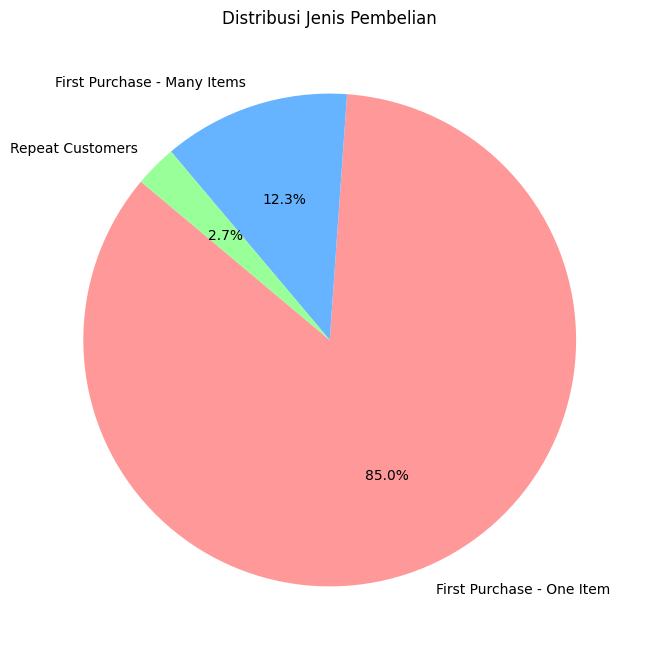

In [277]:
plt.figure(figsize=(8, 8))
plt.pie(data, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'], startangle=140)
plt.title('Distribusi Jenis Pembelian')
plt.show()
